In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

US_NEWS_2020_PATH = "/content/drive/MyDrive/6.S079_Project/data/us_news_2020.csv"
US_NEWS_2019_PATH = "/content/drive/MyDrive/6.S079_Project/data/us_news_2019.csv"

WEIGHTS_2019_PATH = "/content/drive/MyDrive/6.S079_Project/data/2019_weights.csv"
WEIGHTS_2020_PATH = "/content/drive/MyDrive/6.S079_Project/data/2020_weights.csv"

act_percentiles_2020 = {36: 100, 35: 99, 34: 99, 33: 97, 32: 96, 31: 94, 30: 92, 29: 90, 28: 88, 27: 85, 26: 82, 25: 78, 24: 74, 23: 70, 22: 65, 21: 60, 20: 54, 19: 48, 18: 42, 17: 36, 16: 30, 15: 24, 14: 17, 13: 11, 12: 6, 11: 2, 10: 1, 9: 1, 8: 1, 7: 1, 6: 1, 5: 1, 4: 1, 3: 1, 2: 1, 1: 1}

sat_percentiles_2020 = {1600: 100, 1590: 100, 1580: 100, 1570: 100, 1560: 100, 1550: 99, 1540: 99, 1530: 99, 1520: 99, 1510: 98, 1500: 98, 1490: 98, 1480: 97, 1470: 97, 1460: 97, 1450: 96, 1440: 96, 1430: 95, 1420: 95, 1410: 94, 1400: 94, 1390: 93, 1380: 92, 1370: 92, 1360: 91, 1350: 90, 1340: 89, 1330: 89, 1320: 88, 1310: 87, 1300: 86, 1290: 85, 1280: 84, 1270: 83, 1260: 82, 1250: 81, 1240: 80, 1230: 78, 1220: 77, 1210: 76, 1200: 74, 1190: 73, 1180: 72, 1170: 70, 1160: 69, 1150: 67, 1140: 66, 1130: 64, 1120: 62, 1110: 61, 1100: 59, 1090: 57, 1080: 55, 1070: 54, 1060: 52, 1050: 50, 1040: 48, 1030: 46, 1020: 45, 1010: 43, 1000: 41, 990: 39, 980: 38, 970: 36, 960: 34, 950: 33, 940: 31, 930: 29, 920: 28, 910: 26, 900: 25, 890: 23, 880: 22, 870: 20, 860: 19, 850: 18, 840: 16, 830: 15, 820: 14, 810: 12, 800: 11, 790: 10, 780: 9, 770: 8, 760: 7, 750: 6, 740: 5, 730: 5, 720: 4, 710: 3, 700: 3, 690: 2, 680: 2, 670: 1, 660: 1, 650: 1, 640: 1, 630: 1, 620: 1, 610: 1, 600: 1}


Mounted at /content/drive/


In [3]:
# us_news_2019 = pd.read_csv(US_NEWS_2019_PATH)
# weights_2019 = pd.read_csv(WEIGHTS_2019_PATH)


us_news_2020 = pd.read_csv(US_NEWS_2020_PATH)
weights_2020 = pd.read_csv(WEIGHTS_2020_PATH)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
clean_dict = {
    '2020 Rank': ['rank', 'int'],
    'School' : ['school', 'str'],
    'Overall Score': ['score', 'int'],
    'Peer Assessment Score': ['peer_score', 'float64'],
    'Graduation and retention rank': ['graduation_retention_rank', 'int'],
    # 'Average first year retention rate': ['freshman_retention', 'pct'],           EMBODIED BY 'Graduation and retention rank'
    'Over/Underperformance': ['graduation_diff', 'int'],
    # 'Pell Gradrate': ['pell_gradrate', 'pct'],                                    EMBODIED BY 'Social Mobility Rank'
    'Social Mobility Rank': ['social_mobility_rank', 'int'],
    'Faculty resources rank': ['faculty_resources_rank', 'int'],
    # 'Percent of classes under 20': ['small_class_pct', 'pct'],                    EMBODIED BY 'Faculty resources rank'
    # 'Percent of classes of 50 or more students': ['large_class_pct', 'pct'],      EMBODIED BY 'Faculty resources rank'
    # 'Student/faculty ratio': ['student_faculty_ratio', 'ratio'],                  EMBODIED BY 'Faculty resources rank'
    # 'Selectivity rank': ['selectivity_rank', 'int'],                              EMBODIED BY 'Faculty resources rank'
    'SAT/ACT 25th-75th percentile': ['test_scores', 'range'],
    'First year students in top 10% of high school class': ['accomplished_freshman', 'pct'],
    # 'Acceptance rate': ['acceptance_rate', 'pct'],                                NOT IN CRITERIA
    'Financial resources rank': ['financial_resources_rank', 'int'],
    'Average alumni giving rate': ['alum_giving_rate', 'pct'],
}

In [6]:
def ratio_converter(ratio_str):
  numerator, denominator = map(float, ratio_str.split(' to '))
  return numerator / denominator if denominator != 0 else None

def range_converter(range_str):
  if type(range_str) == str:
    bottom, top = map(float, range_str.split('-'))
    # converts the top and bottom range to the ACT/SAT Percentiles for the year 2020
    if top <= 36:
      bottom = act_percentiles_2020[bottom]
      top = act_percentiles_2020[top]
    else:
      bottom = sat_percentiles_2020[round(bottom, -1)]
      top = sat_percentiles_2020[round(top, -1)]
    return (bottom + top)/2
  else: # in case of 'nan' values
     return range_str

def rank_converter(df, col):
  max_rank = df[col].max()
  df[col] = (max_rank + 1 - df[col]) / max_rank
  return df

def clean_2020_data(df, trans_dic):
  for col in df.columns:
    # print(col)
    try:
      _name, _type = trans_dic[col]
      df = df.rename(columns={col: _name})
      if _type in ['int', 'float64']:
        df[_name] = pd.to_numeric(df[_name], errors='coerce')
      elif _type == 'str':
        df[_name] = df[_name].astype('str')
      elif _type == 'pct':
        df[_name] = df[_name].str.rstrip('%').astype(float) / 100
      elif _type == 'ratio':
        df[_name] = df[_name].apply(ratio_converter)
      elif _type == 'range':
        df[_name] = df[_name].apply(range_converter)
    except:
      df = df.drop(columns=col)

  #==========================================
  # CONTEXT DEPENDENT (i.e 2020) TRANSFORMATIONS
  #==========================================
  # 'NaN' represents a difference of 0
  df['graduation_diff'] = df['graduation_diff'].fillna(0)

  # adjust and normalize ranks
  # df['social_mobility_rank'] = df['social_mobility_rank'].apply(lambda v: (max(df.social_mobility_rank) + 1 - v)/max(df.social_mobility_rank))
  # df['faculty_resources_rank'] = df['faculty_resources_rank'].apply(lambda v: (max(df.faculty_resources_rank) + 1 - v)/max(df.faculty_resources_rank))

  df = rank_converter(df, 'social_mobility_rank')
  df = rank_converter(df, 'faculty_resources_rank')
  df = rank_converter(df, 'graduation_retention_rank')

  #==========================================

  return df

In [7]:
clean_2020_df = clean_2020_data(us_news_2020, clean_dict)
display(clean_2020_df)

,rank,school,score,peer_score,graduation_retention_rank,graduation_diff,social_mobility_rank,faculty_resources_rank,test_scores,accomplished_freshman,financial_resources_rank,alum_giving_rate
0,1,Princeton University (NJ),100,4.9,0.997118,1.0,0.514436,0.984252,98.0,0.91,12,0.59
1,2,Harvard University (MA),96,4.9,0.997118,1.0,0.514436,0.986877,98.5,0.94,8,0.31
2,3,Columbia University (NY),94,4.7,0.991354,2.0,0.640420,0.994751,98.0,0.96,13,0.30
3,3,Massachusetts Institute of Technology,94,4.9,0.974063,-1.0,0.370079,0.979003,99.0,0.97,2,0.33
4,3,Yale University (CT),94,4.8,1.000000,0.0,0.254593,0.973753,98.0,0.95,1,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...
287,281,Sam Houston State University (TX),27,2.2,0.201729,6.0,0.782152,0.162730,53.5,0.19,365,0.07
288,281,Univ. of Missouri--St. Louis,27,2.4,0.187320,-11.0,0.750656,0.267717,72.5,0.26,294,0.04
289,281,University of North Florida,27,2.4,0.340058,-2.0,0.700787,0.052493,73.0,0.16,339,0.04
290,281,University of North Texas,27,2.6,0.250720,0.0,0.750656,0.052493,67.0,0.19,376,0.04


**From an older revision of Wikipedia:**




*The following are elements in the U.S. News rankings as of the 2020 edition.*



*   *Peer assessment: a survey of the institution's reputation among presidents, provosts, and admissions deans of other institutions (20%)*
*   *Retention: six-year graduation rate and first-year student retention rate (22%)*
*   *Social mobility: six-year graduation rates of students receiving Pell Grants—both as a standalone measure and compared to graduation rates of all other students at the school—adjusted significantly to give more credit to schools enrolling larger proportions of students receiving Pell Grants. (5%)*
*   *Faculty resources: class sizes, faculty salary, faculty degree level, student-faculty ratio, and proportion of full-time faculty (20%)*
*   *Student excellence: standardized test scores of admitted students and proportion of admitted students in upper percentiles of their high school class.* (unstated; by remainder --> 10%)
*   *Financial resources: per-student spending related to academics, student support and public service. (10%)*
*   *Graduation rate performance: comparison between modeled expected and actual graduation rate (8%)*
*   *Alumni giving rate (5%)*






## Exploring how noise affects rankings - how does schools reporting accuracy affect rankings

**columns to explore:**
*   retention 22%
*   faculty resources 20%
*   financial resources 10%
*   alumni giving rate 5%

**methods:**
1.   applying noise to data

*   run x many trials on each row and aggregate score of how much the rankings change
*   List item


2.   applying noise to weights
3.   applying noise to both



In [8]:
def normalize_df(df, exclude_columns=[]):
    """
    Normalize all columns in the DataFrame to be between 0 and 1,
    except for the columns specified in exclude_columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame to normalize.
    exclude_columns (list): List of columns to exclude from normalization.

    Returns:
    pd.DataFrame: A new DataFrame with normalized values.
    """
    normalized_df = df.copy()
    for column in normalized_df.columns:
        if column not in exclude_columns:
            min_val = normalized_df[column].min()
            max_val = normalized_df[column].max()
            normalized_df[column] = (normalized_df[column] - min_val) / (max_val - min_val)
    return normalized_df

# Example usage
exclude_columns = ['school', 'rank']  # Columns to exclude from normalization
ground_truth_top_20 = normalize_df(clean_2020_df[:50], exclude_columns)

original_weights = {
    'peer_score': 0.2,
    'graduation_retention_rank': 0.22,
    'social_mobility_rank': 0.05,
    'faculty_resources_rank': 0.2,
    'graduation_diff': 0.08,
    'test_scores': 0.075,                # this and one below account for 'Student Excellence (10%)'
    'accomplished_freshman': 0.025,
    'financial_resources_rank': 0.1,
    'alum_giving_rate': 0.05,
}


In [9]:
# calc. column_ranges to be used when applying noise
numeric_ground_truth_top_20 = ground_truth_top_20.drop(columns=['school', 'rank', 'score'])
column_ranges = numeric_ground_truth_top_20.max() - numeric_ground_truth_top_20.min()  # taken from the full dataset
print(column_ranges)


peer_score                   1.0
graduation_retention_rank    1.0
graduation_diff              1.0
social_mobility_rank         1.0
faculty_resources_rank       1.0
test_scores                  1.0
accomplished_freshman        1.0
financial_resources_rank     1.0
alum_giving_rate             1.0
dtype: float64


### Applying noise to the data

In [10]:
def apply_noise_to_column(df, column_name, noise_scale_factor):
    """copy the df and apply noise to the specified column"""
    # Standard deviation of the noise is a fraction of the column's range
    column_range = column_ranges[column_name]
    std_dev = column_range * noise_scale_factor

    # Applying the noise
    noisy_df = df.copy()
    noise = np.random.normal(0, std_dev, size=df[column_name].shape)
    noisy_df[column_name] += noise

    return noisy_df


# display(ground_truth_top_20[['school', 'faculty_resources_rank']])
# display(ground_truth_top_20[['school','rank','faculty_resources_rank']])
# noisy_top_20 = apply_noise_to_column(ground_truth_top_20, 'faculty_resources_rank', .01)
# display(noisy_top_20[['school', 'faculty_resources_rank']])

In [11]:
from scipy.stats import spearmanr

def score_dataset(df, weights):
    # display(df[['school', 'rank']])
    df['new_score'] = df.apply(lambda row: sum(row[col] * weight for col, weight in weights.items()), axis=1)
    # display(df[['school', 'rank']])
    return df


def compare_datasets(df1, df2, column_name):
    """use spearman's rank correlation to compare diff between datasets"""
    correlation, p_value = spearmanr(df1[column_name], df2[column_name])
    # correlation, p_value = spearmanr(df1.sort_values(by=column_name),
    #                                  df2.sort_values(by=column_name))
    return correlation, p_value

# print(compare_datasets(ground_truth_top_20, ground_truth_top_20))

In [12]:
def perform_noise_analysis(df, column_name, noise_scale_factor, num_iters=10):
    correlations = []
    for _ in range(num_iters):
        # apply noise
        noisy_df = apply_noise_to_column(df, column_name, noise_scale_factor)

        # score the noisy data and sort by this score descending
        noisy_df = score_dataset(noisy_df, original_weights).sort_values(by='new_score', ascending=False)
        # display(noisy_df[['school','rank','new_score']])

        # display(ground_truth_top_20[['school','rank']])
        ground = score_dataset(ground_truth_top_20, original_weights).sort_values(by='new_score', ascending=False)

        # calculate difference against ground truth order
        # corr, _ = compare_datasets(noisy_df, ground_truth_top_20, 'school')
        corr, _ = compare_datasets(noisy_df, ground, 'school')
        # print(corr)
        correlations.append(corr)

    # return dfs
    return np.mean(correlations)

In [13]:
correlation = perform_noise_analysis(ground_truth_top_20, 'faculty_resources_rank', 0.01, 100)
print(correlation)
# print(ground_truth_top_20.columns)

0.9162304921968787


In [14]:
def perform_noise_analysis_across_columns(df, noise_scale_factor, num_iters=10):
    mean_correlations = {}
    for col in ['faculty_resources_rank', 'financial_resources_rank', 'alum_giving_rate']:
        mean_corr = perform_noise_analysis(df, col, noise_scale_factor, num_iters=num_iters)
        mean_correlations[col] = mean_corr
    return mean_correlations


Noise Scale Factor = 0.01
{'faculty_resources_rank': 0.9057767106842738, 'financial_resources_rank': 0.9817238895558222, 'alum_giving_rate': 0.9952557022809124}


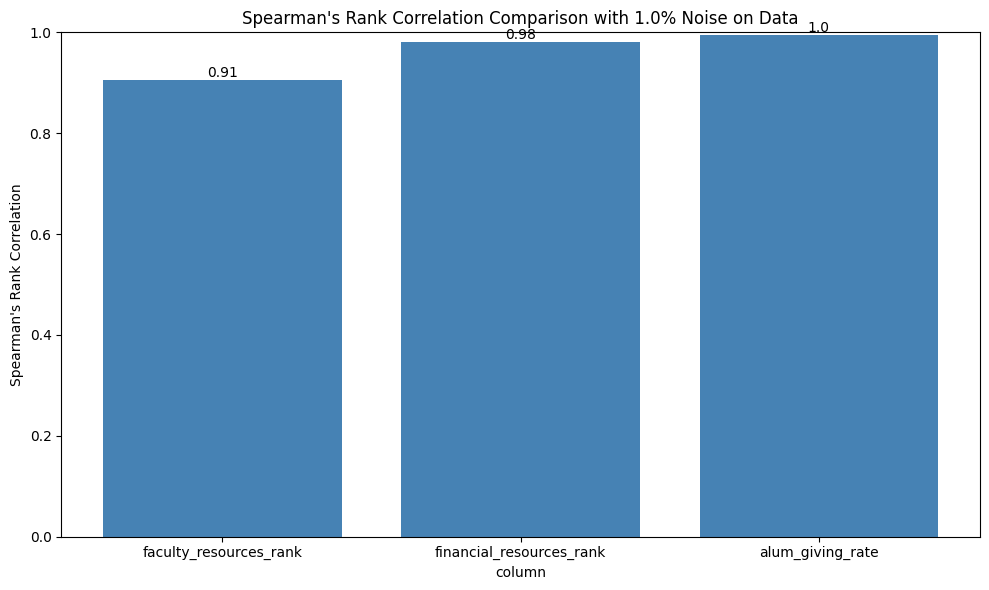

Noise Scale Factor = 0.05
{'faculty_resources_rank': 0.42101320528211283, 'financial_resources_rank': 0.6877599039615846, 'alum_giving_rate': 0.8743433373349341}


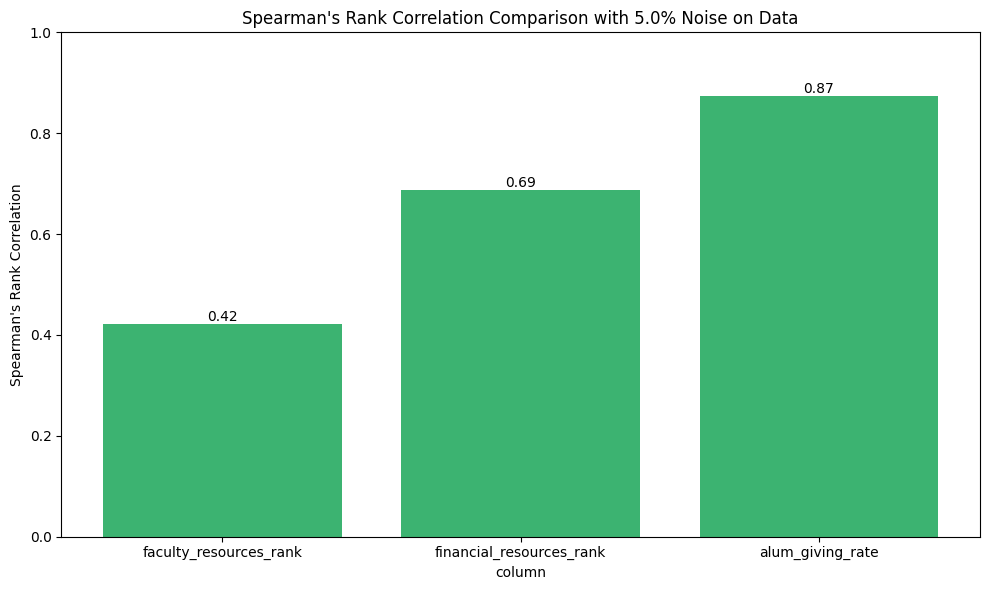

Noise Scale Factor = 0.1
{'faculty_resources_rank': 0.26611284513805517, 'financial_resources_rank': 0.4932244897959183, 'alum_giving_rate': 0.6341320528211284}


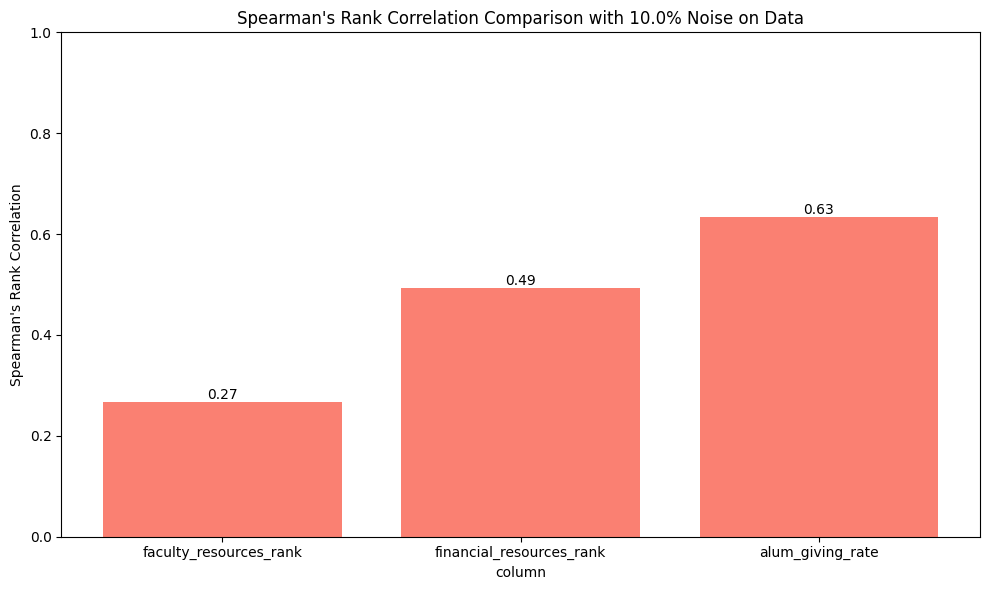

In [15]:
import matplotlib.pyplot as plt

nsf = [0.01, 0.05, 0.10]
colors = ['steelblue', 'mediumseagreen', 'salmon']

def graph_data_noise(df, num_iters):
    for i in range(3):
        print(f"Noise Scale Factor = {nsf[i]}")
        res = perform_noise_analysis_across_columns(df, nsf[i], num_iters)
        print(res)

        # make a bar graph
        values = []
        labels = []
        for col, cor in res.items():
            values.append(cor)
            labels.append(col)

        plt.figure(figsize=(10, 6))
        # plt.bar(labels, values, color=colors[i])
        bars = plt.bar(labels, values, color=colors[i])
        plt.ylim(0, 1)
        plt.xlabel('column')
        plt.ylabel("Spearman's Rank Correlation")
        plt.title(f"Spearman's Rank Correlation Comparison with {nsf[i]*100}% Noise on Data")
        plt.xticks(rotation=0, ha='center')
        plt.tight_layout()

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2),
                     ha='center', va='bottom')

        plt.show()


graph_data_noise(ground_truth_top_20, 10)

**problem**

applying the random noise to the z scores

In [16]:
# display(clean_2020_df[:10])

### Applying noise to the weights

In [17]:
def make_noisy_weights(og_weights, noise_scale_factor=0.1):
    noisy_weights = {}
    for key, weight in og_weights.items():
        new_weight = np.random.normal(weight, noise_scale_factor * weight)
        noisy_weights[key] = new_weight
    total_weight = sum(noisy_weights.values())
    for col in noisy_weights:
        noisy_weights[col] /= total_weight
    return noisy_weights

# noisyW = make_noisy_weights(original_weights, 0.1)
# print(original_weights)
# print(noisyW)


In [18]:
def perform_noisy_weight_analysis(df, weights, noise_scale_factor=0.1, num_iters=10):
    correlations = []

    for _ in range(num_iters):
        new_weights = make_noisy_weights(original_weights, noise_scale_factor)

        # score the data w/ noisy weights and sort by this score descending
        noisy_df = score_dataset(df, new_weights).sort_values(by='new_score', ascending=False)
        ground = score_dataset(df, original_weights).sort_values(by='new_score', ascending=False)

        corr, _ = compare_datasets(noisy_df, ground, 'school')
        correlations.append(corr)

    return np.mean(correlations)

# display(ground_truth_top_20)
# perform_noisy_weight_analysis(ground_truth_top_20, original_weights, 0.1, 100)


Noise Scale Factor = 0.01
0.9926187755102042
Noise Scale Factor = 0.05
0.853782280912365
Noise Scale Factor = 0.1
0.7222443217286914


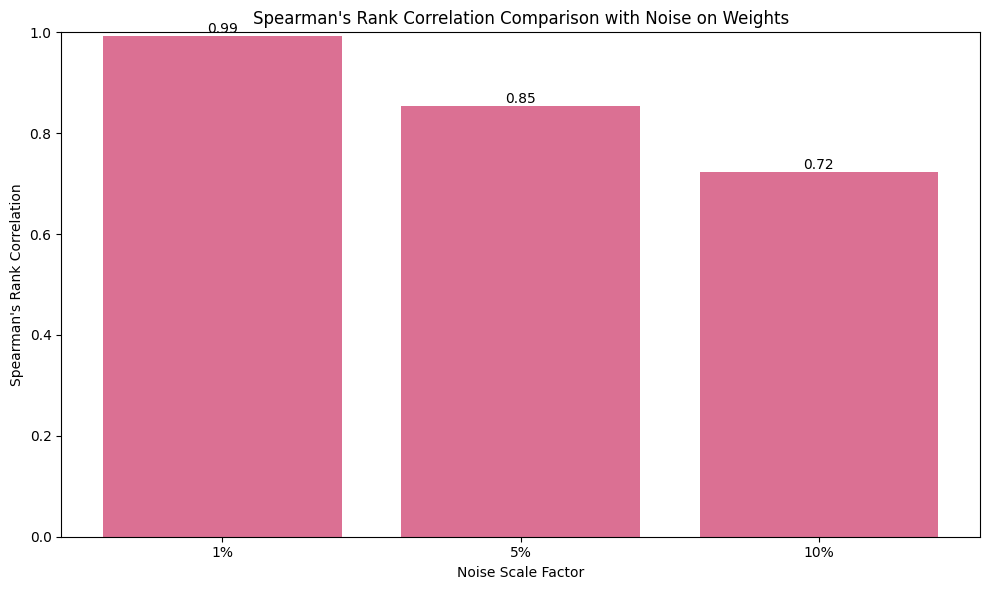

In [19]:
def graph_weight_noise(df, num_iters):
    labels = [0.01, 0.05, 0.10]
    values = []
    for nsf in labels:
        print(f"Noise Scale Factor = {nsf}")
        res = perform_noisy_weight_analysis(ground_truth_top_20, original_weights, nsf, num_iters)
        print(res)
        values.append(res)

    plt.figure(figsize=(10, 6))
    bars = plt.bar([f"{int(label*100)}%" for label in labels], values, color='palevioletred')
    plt.ylim(0, 1)
    plt.xlabel('Noise Scale Factor')
    plt.ylabel("Spearman's Rank Correlation")
    plt.title("Spearman's Rank Correlation Comparison with Noise on Weights")
    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2),
                 ha='center', va='bottom')

    plt.show()


graph_weight_noise(ground_truth_top_20, 1000)